In [ ]:
!pip install datasets opencv-python numpy


# Loading FoodSEg103 dataset

In [ ]:
# STEP 1: Clone dataset (if running in Colab, use shell commands)
!git lfs install
!git clone https://huggingface.co/datasets/EduardoPacheco/FoodSeg103

Git LFS initialized.
Cloning into 'FoodSeg103'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 51 (delta 1), reused 0 (delta 0), pack-reused 35 (from 1)
Unpacking objects: 100% (51/51), 13.17 KiB | 1.01 MiB/s, done.
Filtering content: 100% (4/4), 1.16 GiB | 43.74 MiB/s, done.


In [ ]:
!pip install pandas pyarrow


In [ ]:
import pandas as pd

# Load a training file
df = pd.read_parquet("FoodSeg103/data/train-00000-of-00003.parquet")

# Display structure
print(df.columns)
print(df.head())


Index(['image', 'label', 'classes_on_image', 'id'], dtype='object')
                                               image  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                                               label  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

           classes_on_image  id  
0           [0, 48, 66, 90]   0  
1       [0, 52, 70, 82, 93]   1  
2               [0, 58, 67]   2  
3       [0, 48, 84, 85, 87]   3  
4  [0, 46, 84, 87, 96, 101]   4  


# Coverting Segmentation masks into bounding box annotations

In [ ]:
import os
import io
import json
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

# ======================== CONFIG ========================
DATA_DIR = "/content/FoodSeg103/data"
ID2LABEL_PATH = "/content/FoodSeg103/id2label.json"
OUTPUT_DIR = "/content/foodseg103_yolo_deterministic"
SPLIT_RATIO = 0.8  # 80% train, 20% valid

# ======================== SETUP ========================
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load all parquet files
parquet_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.parquet')]
df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)

# Load class names
with open(ID2LABEL_PATH, 'r') as f:
    id2label = json.load(f)

# ======================== DETERMINISTIC SPLIT ========================
# Sequential split (no randomization)
split_idx = int(len(df) * SPLIT_RATIO)
train_indices = df.index[:split_idx]  # First 80%
valid_indices = df.index[split_idx:]  # Last 20%

print(f"Total images: {len(df)}")
print(f"Train images: {len(train_indices)}")
print(f"Valid images: {len(valid_indices)}")

# ======================== CONVERSION FUNCTIONS ========================
def convert_to_yolo(size, box):
    """Convert bounding box to YOLO format (normalized xywh)."""
    w_img, h_img = size
    x1, y1, x2, y2 = box
    x_c = ((x1 + x2) / 2) / w_img
    y_c = ((y1 + y2) / 2) / h_img
    w = (x2 - x1) / w_img
    h = (y2 - y1) / h_img
    return [x_c, y_c, w, h]

# ======================== PROCESS DATASET ========================
for split, indices in [('train', train_indices), ('valid', valid_indices)]:
    # Create directories
    os.makedirs(os.path.join(OUTPUT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, "labels"), exist_ok=True)

    for idx in tqdm(indices, desc=f"Processing {split} set"):
        row = df.loc[idx]
        try:
            # Load image and mask
            image = Image.open(io.BytesIO(row['image']['bytes'])).convert("RGB")
            mask = Image.open(io.BytesIO(row['label']['bytes'])).convert("L")
        except:
            print(f"Skipping corrupt image/mask at index {idx}")
            continue

        # Save image
        img_path = os.path.join(OUTPUT_DIR, split, "images", f"{idx:05d}.jpg")
        image.save(img_path)

        # Convert mask to YOLO labels
        mask_np = np.array(mask)
        class_ids = np.unique(mask_np)
        class_ids = class_ids[class_ids != 0]  # Exclude background

        # Save annotations
        lbl_path = os.path.join(OUTPUT_DIR, split, "labels", f"{idx:05d}.txt")
        with open(lbl_path, "w") as f:
            for cid in class_ids:
                binary_mask = (mask_np == cid).astype(np.uint8)
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    if cv2.contourArea(contour) < 100:  # Skip small objects
                        continue
                    x, y, w, h = cv2.boundingRect(contour)
                    yolo_box = convert_to_yolo(image.size, [x, y, x + w, y + h])
                    f.write(f"{cid - 1} " + " ".join(f"{b:.6f}" for b in yolo_box) + "\n")

# ======================== GENERATE DATA.YAML ========================
yaml_path = os.path.join(OUTPUT_DIR, "data.yaml")
names = [id2label[str(i)].strip() for i in range(1, 104)]  # Class names (1-103)

with open(yaml_path, "w") as f:
    f.write(f"train: {os.path.join(OUTPUT_DIR, 'train', 'images')}\n")
    f.write(f"val: {os.path.join(OUTPUT_DIR, 'valid', 'images')}\n")
    f.write(f"nc: {len(names)}\n")
    f.write("names: [" + ", ".join(f"'{name}'" for name in names) + "]\n")

print("\n✅ Conversion complete!")
print(f"YOLO dataset saved to: {OUTPUT_DIR}")
print(f"Class count: {len(names)}")
print(f"Train images: {len(train_indices)}")
print(f"Valid images: {len(valid_indices)}")


Total images: 7118
Train images: 5694
Valid images: 1424


Processing valid set: 100%|██████████| 1424/1424 [00:52<00:00, 27.36it/s]


✅ Conversion complete!
YOLO dataset saved to: /content/foodseg103_yolo_deterministic
Class count: 103
Train images: 5694
Valid images: 1424


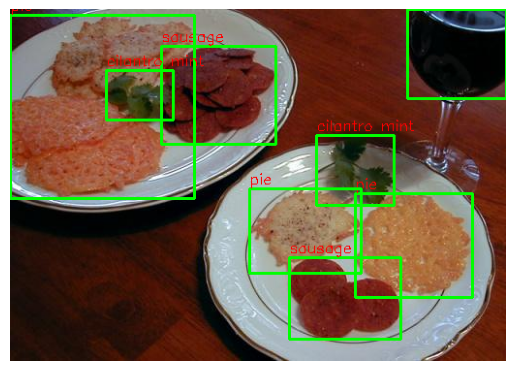

In [ ]:
import matplotlib.pyplot as plt

def plot_sample(split, idx):
    img_path = os.path.join(OUTPUT_DIR, split, "images", f"{idx:05d}.jpg")
    lbl_path = os.path.join(OUTPUT_DIR, split, "labels", f"{idx:05d}.txt")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    with open(lbl_path, "r") as f:
        for line in f:
            cid, xc, yc, bw, bh = map(float, line.strip().split())
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, names[int(cid)], (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

plot_sample("train", train_indices[11])  # Plot first training sample

#Printing class labels

In [ ]:
import json

# Load class names
with open("/content/FoodSeg103/id2label.json", "r") as f:
    id2label = json.load(f)

# Print all classes (excluding background)
print("=== FoodSeg103 Class Labels ===")
for class_id, label in sorted(id2label.items(), key=lambda x: int(x[0])):
    if int(class_id) == 0:
        continue  # Skip background
    print(f"{int(class_id)-1:3d} : {label.strip()}")  # YOLO IDs start at 0

=== FoodSeg103 Class Labels ===
  0 : candy
  1 : egg tart
  2 : french fries
  3 : chocolate
  4 : biscuit
  5 : popcorn
  6 : pudding
  7 : ice cream
  8 : cheese butter
  9 : cake
 10 : wine
 11 : milkshake
 12 : coffee
 13 : juice
 14 : milk
 15 : tea
 16 : almond
 17 : red beans
 18 : cashew
 19 : dried cranberries
 20 : soy
 21 : walnut
 22 : peanut
 23 : egg
 24 : apple
 25 : date
 26 : apricot
 27 : avocado
 28 : banana
 29 : strawberry
 30 : cherry
 31 : blueberry
 32 : raspberry
 33 : mango
 34 : olives
 35 : peach
 36 : lemon
 37 : pear
 38 : fig
 39 : pineapple
 40 : grape
 41 : kiwi
 42 : melon
 43 : orange
 44 : watermelon
 45 : steak
 46 : pork
 47 : chicken duck
 48 : sausage
 49 : fried meat
 50 : lamb
 51 : sauce
 52 : crab
 53 : fish
 54 : shellfish
 55 : shrimp
 56 : soup
 57 : bread
 58 : corn
 59 : hamburg
 60 : pizza
 61 : hanamaki baozi
 62 : wonton dumplings
 63 : pasta
 64 : noodles
 65 : rice
 66 : pie
 67 : tofu
 68 : eggplant
 69 : potato
 70 : garlic
 71 :

# Printing class labels along with count

In [ ]:
from collections import defaultdict

# Count class occurrences
class_counts = defaultdict(int)
for classes in df['classes_on_image']:
    for c in classes:
        if c != 0:  # Skip background
            class_counts[c] += 1

# Print sorted by frequency
print("=== Class Counts ===")
for c in sorted(class_counts, key=lambda x: -class_counts[x]):
    print(f"{c-1:3d} : {id2label[str(c)].strip():<25} (count: {class_counts[c]})")

=== Class Counts ===
 57 : bread                     (count: 1405)
 83 : carrot                    (count: 1279)
 47 : chicken duck              (count: 1242)
 51 : sauce                     (count: 1145)
 72 : tomato                    (count: 1139)
 69 : potato                    (count: 1091)
 45 : steak                     (count: 1065)
 86 : broccoli                  (count: 1013)
  7 : ice cream                 (count: 913)
 88 : cilantro mint             (count: 900)
 65 : rice                      (count: 670)
 46 : pork                      (count: 669)
 36 : lemon                     (count: 595)
 79 : lettuce                   (count: 574)
 29 : strawberry                (count: 560)
 66 : pie                       (count: 558)
 81 : cucumber                  (count: 533)
 92 : onion                     (count: 532)
 58 : corn                      (count: 488)
  9 : cake                      (count: 459)
 93 : pepper                    (count: 436)
  8 : cheese butter       

In [ ]:
!zip -r /content/foodseg103_yolo_deterministic.zip /content/foodseg103_yolo_deterministic


Streaming output truncated to the last 5000 lines.
  adding: content/foodseg103_yolo_deterministic/train/images/03869.jpg (deflated 1%)
  adding: content/foodseg103_yolo_deterministic/train/images/04008.jpg (deflated 1%)
  adding: content/foodseg103_yolo_deterministic/train/images/01730.jpg (deflated 1%)
  adding: content/foodseg103_yolo_deterministic/train/images/04672.jpg (deflated 4%)
  adding: content/foodseg103_yolo_deterministic/train/images/04657.jpg (deflated 1%)
  adding: content/foodseg103_yolo_deterministic/train/images/00134.jpg (deflated 4%)
  adding: content/foodseg103_yolo_deterministic/train/images/03309.jpg (deflated 0%)
  adding: content/foodseg103_yolo_deterministic/train/images/02330.jpg (deflated 1%)
  adding: content/foodseg103_yolo_deterministic/train/images/02645.jpg (deflated 0%)
  adding: content/foodseg103_yolo_deterministic/train/images/04194.jpg (deflated 0%)
  adding: content/foodseg103_yolo_deterministic/train/images/02224.jpg (deflated 1%)
  adding: cont

# Saving to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then copy the file to your drive
!cp /content/foodseg103_yolo_deterministic.zip /content/drive/MyDrive/


Mounted at /content/drive
